# 📊 Phase 2 — Pricing Analysis
## Olist Pricing Intelligence

---

**Objectif :** Analyser en profondeur la structure des prix, des marges et des comportements d'achat pour produire des **insights actionnables** à destination des Category Managers, de la Finance et de l'E-commerce.

**Input :** `data/processed/olist_pricing_dataset.csv` (output Phase 1)

**Sections :**

| # | Analyse | Compétence démontrée |
|---|---|---|
| 2.1 | Prix par catégorie | Positionnement, segmentation |
| 2.2 | Analyse de la marge | Rentabilité, priorisation |
| 2.3 | Analyse temporelle | Saisonnalité, tendances |
| 2.4 | Comportement d'achat | Satisfaction, paiement échelonné |
| 2.5 | Analyse géographique | Coût logistique, disparités régionales |

---

## Table des matières

1. [Imports & Configuration](#1-imports)
2. [Chargement des données](#2-chargement)
3. [2.1 — Prix par catégorie](#21-prix)
4. [2.2 — Analyse de la marge](#22-marge)
5. [2.3 — Analyse temporelle](#23-temps)
6. [2.4 — Comportement d'achat & prix](#24-achat)
7. [2.5 — Analyse géographique](#25-geo)
8. [Synthèse des insights](#synthese)

---
## 1. Imports & Configuration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
import os
warnings.filterwarnings("ignore")

# ── Style global ──────────────────────────────────────────
plt.rcParams.update({
    "figure.facecolor":  "#F8F9FA",
    "axes.facecolor":    "#FFFFFF",
    "axes.spines.top":   False,
    "axes.spines.right": False,
    "font.family":       "sans-serif",
    "axes.titlesize":    13,
    "axes.titleweight":  "bold",
    "axes.labelsize":    11,
    "xtick.labelsize":   10,
    "ytick.labelsize":   10,
})

# ── Palette Okabe-Ito (daltonisme-friendly) ───────────────
PALETTE = [
    "#E69F00",  # Orange
    "#56B4E9",  # Bleu ciel
    "#009E73",  # Vert
    "#F0E442",  # Jaune
    "#0072B2",  # Bleu foncé
    "#D55E00",  # Vermillon
    "#CC79A7",  # Rose/mauve
    "#000000",  # Noir
]

# ── Chemins ───────────────────────────────────────────────
DATA_IN = "../data/processed/olist_pricing_dataset.csv"
IMG_OUT = "../outputs/"
os.makedirs(IMG_OUT, exist_ok=True)

def save_fig(name):
    path = os.path.join(IMG_OUT, name)
    plt.savefig(path, dpi=150, bbox_inches="tight")
    print(f"  ✅ Sauvegardé : {path}")

def insight(text):
    """Affiche un insight business mis en évidence."""
    print(f"\n  💡 INSIGHT : {text}\n")

print("✅ Configuration OK")

✅ Configuration OK


---
## 2. Chargement des données

In [4]:
df = pd.read_csv(DATA_IN, parse_dates=["order_purchase_timestamp"])
df["price_segment_eur"] = pd.Categorical(
    df["price_segment_eur"],
    categories=df["price_segment_eur"].dropna().unique(),
    ordered=True
)

print(f"Dataset chargé : {len(df):,} lignes × {df.shape[1]} colonnes")
print(f"Période        : {df['month_label'].min()} → {df['month_label'].max()}")
print(f"Catégories     : {df['category_en'].nunique()}")
df.head(3)

Dataset chargé : 110,197 lignes × 33 colonnes
Période        : 2016-09 → 2018-08
Catégories     : 73


,order_id,order_item_id,product_id,seller_id,customer_id,order_purchase_timestamp,year,month,quarter,month_label,...,estimated_margin_eur,price_segment_eur,payment_type,payment_installments,payment_value,payment_value_eur,is_installment,review_score_avg,same_state_delivery,product_weight_g
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,2017,9,3,2017-09,...,4.24,8.0–24.0€,credit_card,2.0,72.19,11.55,1,5.0,0,650.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,2017,4,2,2017-04,...,17.27,24.0–48.0€,credit_card,3.0,259.83,41.57,1,4.0,1,30000.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,2018,1,1,2018-01,...,14.33,24.0–48.0€,credit_card,5.0,216.87,34.70,1,5.0,1,3050.0


---
## 2.1 — Prix par catégorie

Objectif : identifier le **positionnement prix** de chaque catégorie — prix moyen, médian, dispersion — pour détecter les catégories premium, les segments sous-pricés et les anomalies tarifaires.

In [5]:
cat_price = (
    df.groupby("category_en")
    .agg(
        nb_items      = ("order_id", "count"),
        avg_price     = ("price_eur", "mean"),
        median_price  = ("price_eur", "median"),
        std_price     = ("price_eur", "std"),
        p10           = ("price_eur", lambda x: x.quantile(0.10)),
        p90           = ("price_eur", lambda x: x.quantile(0.90)),
        total_revenue = ("price_eur", "sum"),
    )
    .round(2)
    .sort_values("median_price", ascending=False)
    .reset_index()
)
# Coefficient de variation = dispersion relative des prix
cat_price["cv"] = (cat_price["std_price"] / cat_price["avg_price"]).round(2)

print("Top 5 catégories — prix médian le plus élevé :")
print(cat_price[["category_en", "median_price", "avg_price", "cv"]].head(5).to_string(index=False))
print("\nTop 5 catégories — prix médian le plus bas :")
print(cat_price[["category_en", "median_price", "avg_price", "cv"]].tail(5).to_string(index=False))

Top 5 catégories — prix médian le plus élevé :
                          category_en  median_price  avg_price   cv
                            computers        176.00     175.83 0.61
small_appliances_home_oven_and_coffee        102.56     102.11 0.97
           agro_industry_and_commerce         39.00      54.81 1.24
                    home_appliances_2         36.48      74.77 1.14
                    furniture_bedroom         28.64      29.59 0.67

Top 5 catégories — prix médian le plus bas :
                                  category_en  median_price  avg_price   cv
Portateis Cozinha E Preparadores De Alimentos          4.51      44.95 1.50
                                      flowers          4.16       5.38 0.50
                                  electronics          3.50       9.09 2.16
                                 dvds_blu_ray          3.18      11.91 2.72
                               home_comfort_2          2.06       4.05 1.65


  ✅ Sauvegardé : ../outputs/phase2_21_prix_categorie.png


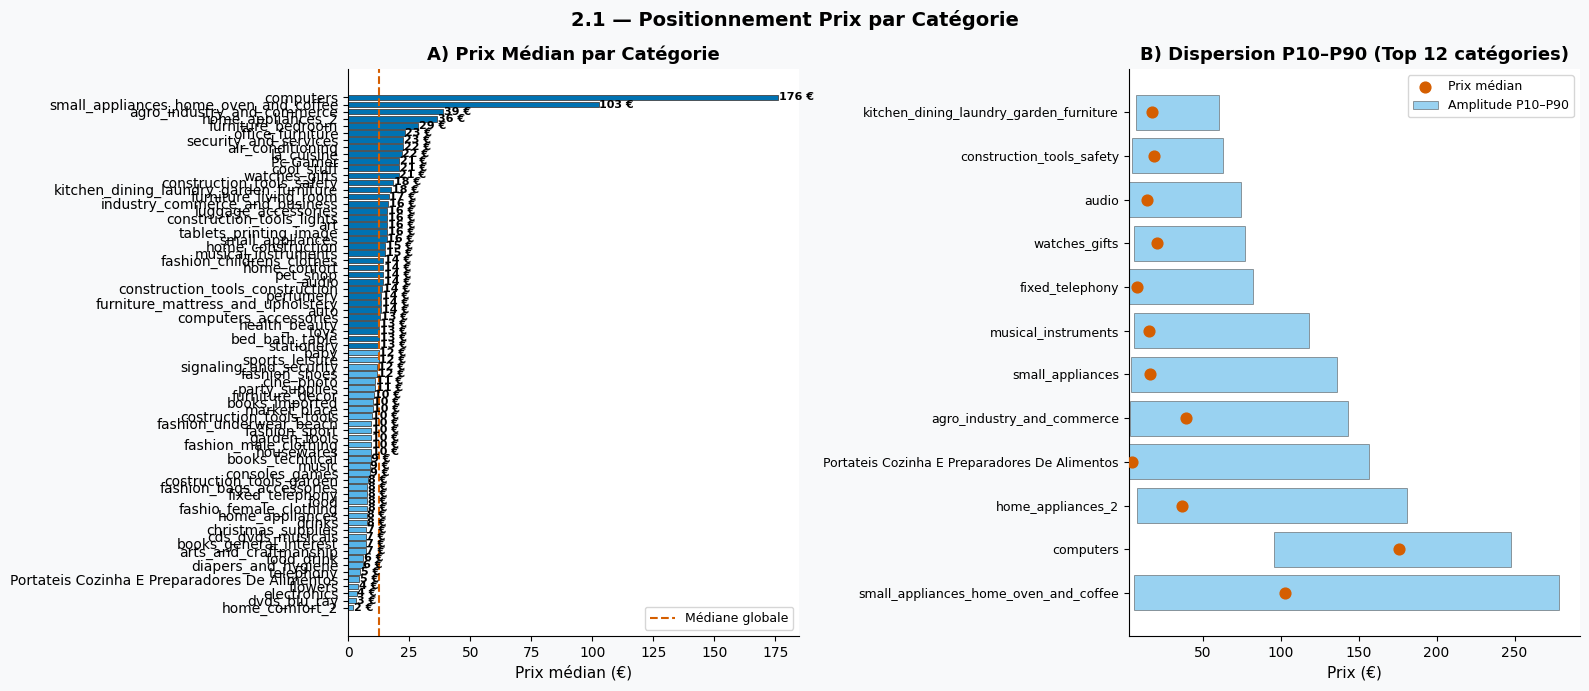


  💡 INSIGHT : 'computers' est la catégorie au prix médian le plus élevé. 'art' présente la plus forte dispersion tarifaire — signal d'une opportunité de rationalisation des prix.



In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("2.1 — Positionnement Prix par Catégorie", fontsize=14, fontweight="bold")

# A) Prix médian par catégorie (barres horizontales)
ax = axes[0]
sorted_cat = cat_price.sort_values("median_price")
colors = [PALETTE[4] if v > cat_price["median_price"].median() else PALETTE[1]
          for v in sorted_cat["median_price"]]
bars = ax.barh(sorted_cat["category_en"], sorted_cat["median_price"],
               color=colors, edgecolor="#444444", linewidth=0.6)
ax.axvline(cat_price["median_price"].median(), color=PALETTE[5],
           lw=1.5, linestyle="--", label="Médiane globale")
ax.set_xlabel("Prix médian (€)")
ax.set_title("A) Prix Médian par Catégorie")
ax.legend(fontsize=9)
for bar, val in zip(bars, sorted_cat["median_price"]):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
            f"{val:.0f} €", va="center", fontsize=8, fontweight="bold")

# B) Dispersion des prix (amplitude P10-P90)
ax = axes[1]
sorted_cv = cat_price.sort_values("p90", ascending=False).head(12)
y_pos = range(len(sorted_cv))
ax.barh(y_pos, sorted_cv["p90"] - sorted_cv["p10"],
        left=sorted_cv["p10"],
        color=PALETTE[1], alpha=0.6, edgecolor="#444444", linewidth=0.6,
        label="Amplitude P10–P90")
ax.scatter(sorted_cv["median_price"], y_pos,
           color=PALETTE[5], zorder=5, s=60, label="Prix médian")
ax.set_yticks(list(y_pos))
ax.set_yticklabels(sorted_cv["category_en"], fontsize=9)
ax.set_xlabel("Prix (€)")
ax.set_title("B) Dispersion P10–P90 (Top 12 catégories)")
ax.legend(fontsize=9)

plt.tight_layout()
save_fig("phase2_21_prix_categorie.png")
plt.show()

top_premium = cat_price.iloc[0]["category_en"]
top_cv = cat_price.sort_values("cv", ascending=False).iloc[0]["category_en"]
insight(f"'{top_premium}' est la catégorie au prix médian le plus élevé. "
        f"'{top_cv}' présente la plus forte dispersion tarifaire — "
        f"signal d'une opportunité de rationalisation des prix.")

---
## 2.2 — Analyse de la marge

Objectif : identifier les catégories les plus **rentables en valeur absolue et relative**, et détecter les catégories à fort volume mais faible marge qui méritent une révision tarifaire.

In [7]:
cat_margin = (
    df.groupby("category_en")
    .agg(
        total_revenue     = ("price_eur", "sum"),
        total_margin      = ("estimated_margin_eur", "sum"),
        avg_margin_pct    = ("estimated_margin_pct", "mean"),
        nb_items          = ("order_id", "count"),
        avg_freight_ratio = ("freight_ratio", "mean"),
    )
    .round(2)
    .reset_index()
)
cat_margin["revenue_share"] = (
    cat_margin["total_revenue"] / cat_margin["total_revenue"].sum() * 100
).round(1)
cat_margin["margin_share"] = (
    cat_margin["total_margin"] / cat_margin["total_margin"].sum() * 100
).round(1)

cat_margin_sorted = cat_margin.sort_values("total_margin", ascending=False)
print("Top 5 catégories — marge totale :")
print(cat_margin_sorted[
    ["category_en", "total_revenue", "total_margin", "revenue_share", "margin_share"]
].head(5).to_string(index=False))

Top 5 catégories — marge totale :
          category_en  total_revenue  total_margin  revenue_share  margin_share
        health_beauty      197292.93      88781.81            9.4           9.4
        watches_gifts      186583.96      83967.54            8.9           8.9
       bed_bath_table      163731.08      73679.36            7.8           7.8
       sports_leisure      152765.82      68744.59            7.3           7.3
computers_accessories      142187.07      63987.02            6.8           6.8


  ✅ Sauvegardé : ../outputs/phase2_22_marge.png


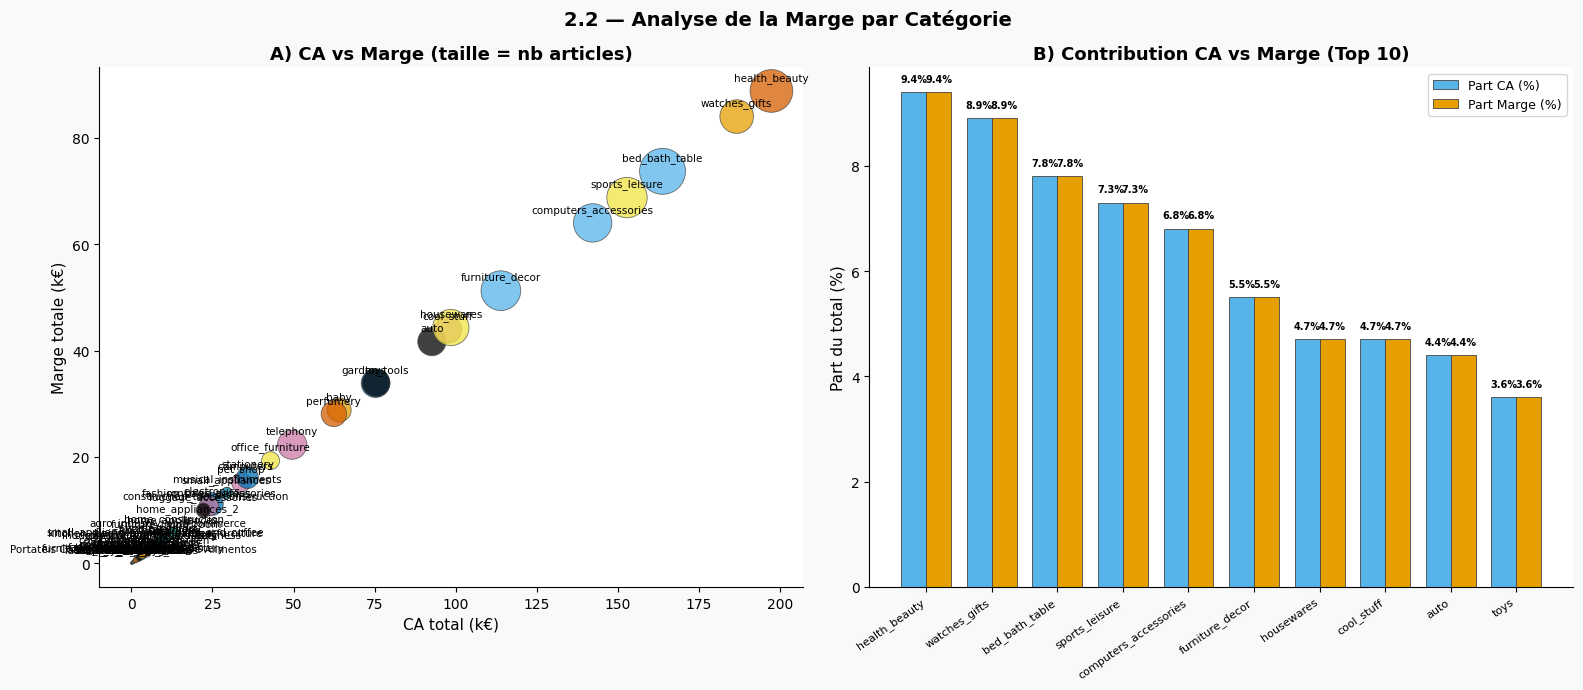


  💡 INSIGHT : 'health_beauty' génère 9.4% de la marge totale pour 9.4% du CA — catégorie prioritaire à protéger en pricing.



In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("2.2 — Analyse de la Marge par Catégorie", fontsize=14, fontweight="bold")

# A) CA vs Marge — bubble chart
ax = axes[0]
scatter = ax.scatter(
    cat_margin["total_revenue"] / 1e3,
    cat_margin["total_margin"] / 1e3,
    s=cat_margin["nb_items"] / 10,
    c=[PALETTE[i % len(PALETTE)] for i in range(len(cat_margin))],
    alpha=0.75, edgecolors="#444444", linewidth=0.6
)
for _, row in cat_margin.iterrows():
    ax.annotate(
        row["category_en"],
        xy=(row["total_revenue"] / 1e3, row["total_margin"] / 1e3),
        fontsize=7.5, ha="center", va="bottom",
        xytext=(0, 6), textcoords="offset points"
    )
ax.set_xlabel("CA total (k€)")
ax.set_ylabel("Marge totale (k€)")
ax.set_title("A) CA vs Marge (taille = nb articles)")

# B) Part de marge vs part de CA (matrice contribution)
ax = axes[1]
top10 = cat_margin.sort_values("total_margin", ascending=False).head(10)
x = np.arange(len(top10))
w = 0.38
b1 = ax.bar(x - w/2, top10["revenue_share"], w,
            color=PALETTE[1], label="Part CA (%)", edgecolor="#444444", lw=0.6)
b2 = ax.bar(x + w/2, top10["margin_share"], w,
            color=PALETTE[0], label="Part Marge (%)", edgecolor="#444444", lw=0.6)
ax.set_xticks(x)
ax.set_xticklabels(top10["category_en"], rotation=35, ha="right", fontsize=8)
ax.set_ylabel("Part du total (%)")
ax.set_title("B) Contribution CA vs Marge (Top 10)")
ax.legend(fontsize=9)
for bar, val in zip(b1, top10["revenue_share"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f"{val:.1f}%", ha="center", fontsize=7, fontweight="bold")
for bar, val in zip(b2, top10["margin_share"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f"{val:.1f}%", ha="center", fontsize=7, fontweight="bold")

plt.tight_layout()
save_fig("phase2_22_marge.png")
plt.show()

top_m = cat_margin_sorted.iloc[0]
insight(f"'{top_m['category_en']}' génère {top_m['margin_share']:.1f}% de la marge totale "
        f"pour {top_m['revenue_share']:.1f}% du CA — catégorie prioritaire à protéger en pricing.")

---
## 2.3 — Analyse temporelle

Objectif : identifier les **tendances de prix** dans le temps, détecter une éventuelle **saisonnalité** et mesurer l'évolution de la marge sur la période.

In [9]:
monthly = (
    df.groupby("month_label")
    .agg(
        nb_orders      = ("order_id", "nunique"),
        nb_items       = ("order_id", "count"),
        avg_price      = ("price_eur", "mean"),
        median_price   = ("price_eur", "median"),
        total_revenue  = ("price_eur", "sum"),
        total_margin   = ("estimated_margin_eur", "sum"),
        avg_freight    = ("freight_value_eur", "mean"),
    )
    .round(2)
    .reset_index()
    .sort_values("month_label")
)
monthly["margin_rate"] = (
    monthly["total_margin"] / monthly["total_revenue"] * 100
).round(1)

# Saisonnalité : prix moyen par mois calendaire (tous mois confondus)
seasonal = (
    df.groupby("month")["price_eur"]
    .agg(["mean", "median", "count"])
    .round(2)
    .reset_index()
)
MONTH_LABELS = ["Jan","Fév","Mar","Avr","Mai","Juin",
                "Juil","Août","Sep","Oct","Nov","Déc"]
seasonal["month_name"] = seasonal["month"].apply(lambda m: MONTH_LABELS[m-1])

print(f"Mois avec le prix moyen le plus élevé : "
      f"{seasonal.loc[seasonal['mean'].idxmax(), 'month_name']} "
      f"({seasonal['mean'].max():.2f} €)")
print(f"Mois avec le prix moyen le plus bas   : "
      f"{seasonal.loc[seasonal['mean'].idxmin(), 'month_name']} "
      f"({seasonal['mean'].min():.2f} €)")

Mois avec le prix moyen le plus élevé : Sep (20.51 €)
Mois avec le prix moyen le plus bas   : Fév (18.10 €)


  ✅ Sauvegardé : ../outputs/phase2_23_temporel.png


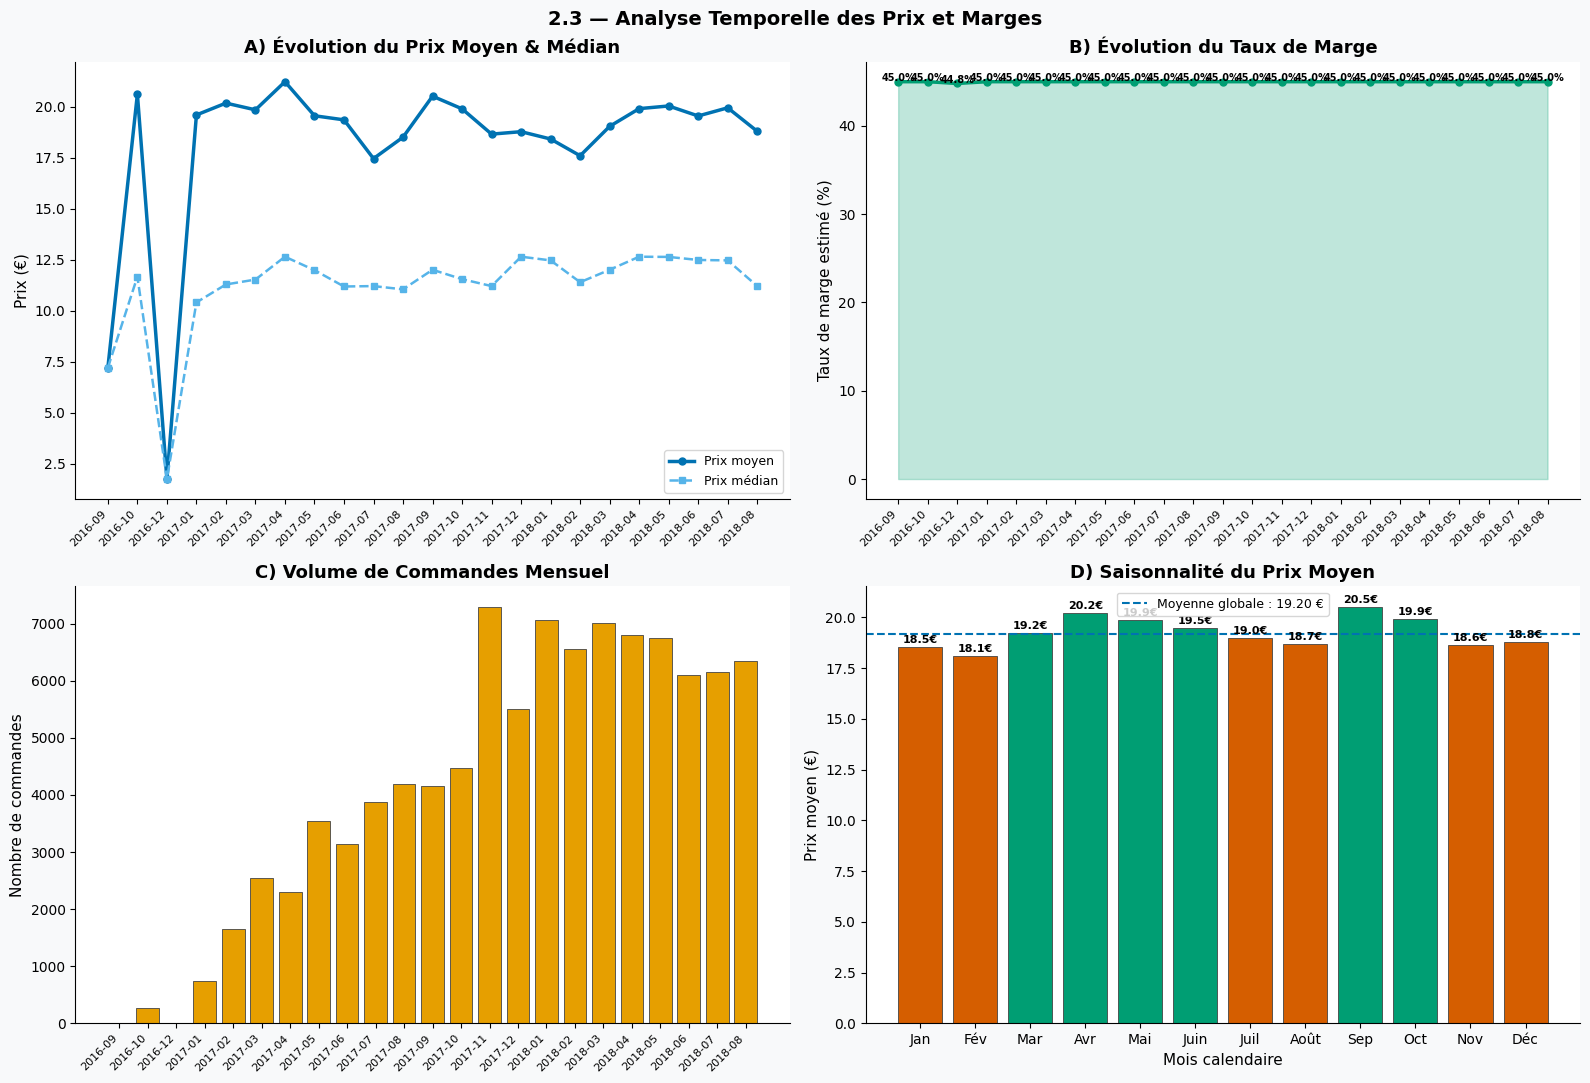


  💡 INSIGHT : Les prix sont en moyenne plus élevés en Sep et plus bas en Fév — une stratégie de pricing dynamique saisonnier pourrait optimiser les marges.



In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle("2.3 — Analyse Temporelle des Prix et Marges", fontsize=14, fontweight="bold")

x = range(len(monthly))
xlabels = monthly["month_label"].tolist()

# A) Évolution du prix moyen mensuel
ax = axes[0, 0]
ax.plot(x, monthly["avg_price"], color=PALETTE[4], lw=2.5,
        marker="o", ms=5, label="Prix moyen")
ax.plot(x, monthly["median_price"], color=PALETTE[1], lw=1.8,
        marker="s", ms=4, linestyle="--", label="Prix médian")
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("Prix (€)")
ax.set_title("A) Évolution du Prix Moyen & Médian")
ax.legend(fontsize=9)

# B) Évolution du taux de marge mensuel
ax = axes[0, 1]
ax.fill_between(x, monthly["margin_rate"], alpha=0.25, color=PALETTE[2])
ax.plot(x, monthly["margin_rate"], color=PALETTE[2], lw=2.5,
        marker="o", ms=5)
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("Taux de marge estimé (%)")
ax.set_title("B) Évolution du Taux de Marge")
for xi, val in zip(x, monthly["margin_rate"]):
    ax.text(xi, val + 0.1, f"{val:.1f}%", ha="center", fontsize=7, fontweight="bold")

# C) Volume de commandes mensuel
ax = axes[1, 0]
bars = ax.bar(x, monthly["nb_orders"],
              color=PALETTE[0], edgecolor="#444444", lw=0.6)
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("Nombre de commandes")
ax.set_title("C) Volume de Commandes Mensuel")

# D) Saisonnalité — prix moyen par mois calendaire
ax = axes[1, 1]
global_avg = df["price_eur"].mean()
colors_s = [PALETTE[2] if v >= global_avg else PALETTE[5] for v in seasonal["mean"]]
bars2 = ax.bar(seasonal["month_name"], seasonal["mean"],
               color=colors_s, edgecolor="#444444", lw=0.6)
ax.axhline(global_avg, color=PALETTE[4], lw=1.5, linestyle="--",
           label=f"Moyenne globale : {global_avg:.2f} €")
ax.set_xlabel("Mois calendaire")
ax.set_ylabel("Prix moyen (€)")
ax.set_title("D) Saisonnalité du Prix Moyen")
ax.legend(fontsize=9)
for bar, val in zip(bars2, seasonal["mean"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f"{val:.1f}€", ha="center", fontsize=8, fontweight="bold")

plt.tight_layout()
save_fig("phase2_23_temporel.png")
plt.show()

peak_month = seasonal.loc[seasonal["mean"].idxmax(), "month_name"]
low_month  = seasonal.loc[seasonal["mean"].idxmin(), "month_name"]
insight(f"Les prix sont en moyenne plus élevés en {peak_month} et plus bas en {low_month} — "
        f"une stratégie de pricing dynamique saisonnier pourrait optimiser les marges.")

---
## 2.4 — Comportement d'achat & prix

Objectif : mesurer l'impact du prix sur la **satisfaction client** (score de review) et analyser le recours au **paiement en plusieurs fois** selon le niveau de prix.

In [11]:
# Score moyen par segment de prix
seg_review = (
    df.groupby("price_segment_eur", observed=True)
    .agg(
        avg_review       = ("review_score_avg", "mean"),
        avg_price        = ("price_eur", "mean"),
        installment_rate = ("is_installment", "mean"),
        nb_items         = ("order_id", "count"),
    )
    .round(3)
    .reset_index()
)

# Corrélation prix / review score
corr = df[["price_eur", "review_score_avg"]].dropna().corr().iloc[0, 1]
print(f"Corrélation prix / score de review : {corr:.3f}")

# Taux de versements multiples par segment
print("\nTaux de paiement en plusieurs fois par segment :")
print(seg_review[["price_segment_eur","installment_rate","avg_review"]].to_string(index=False))

Corrélation prix / score de review : 0.003

Taux de paiement en plusieurs fois par segment :
price_segment_eur  installment_rate  avg_review
        8.0–24.0€             0.553       4.076
       24.0–48.0€             0.694       4.101
           < 8.0€             0.371       4.077
          > 80.0€             0.772       4.100
       48.0–80.0€             0.759       4.126


  ✅ Sauvegardé : ../outputs/phase2_24_comportement.png


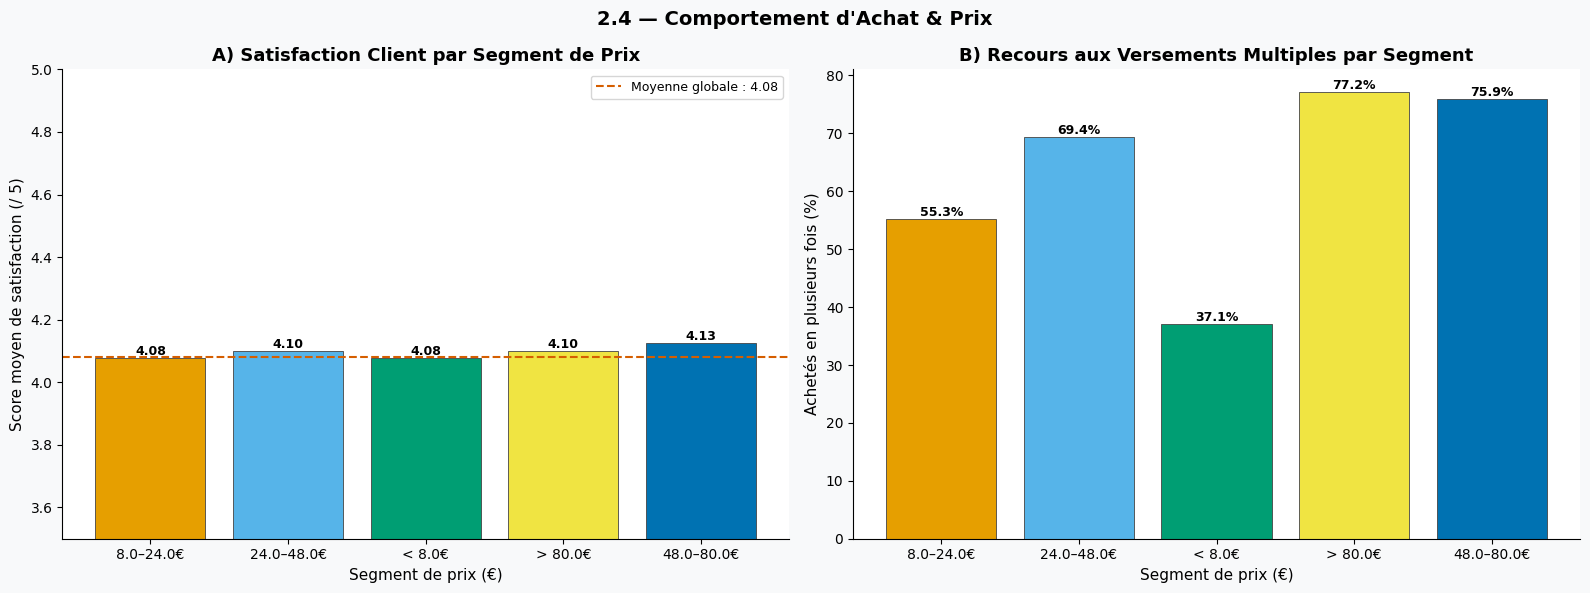


  💡 INSIGHT : La satisfaction est maximale dans le segment '48.0–80.0€'. Le segment '> 80.0€' recourt le plus aux versements multiples — levier à intégrer dans la stratégie de prix affichés.



In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("2.4 — Comportement d'Achat & Prix", fontsize=14, fontweight="bold")

# A) Score de satisfaction par segment de prix
ax = axes[0]
bars = ax.bar(
    seg_review["price_segment_eur"].astype(str),
    seg_review["avg_review"],
    color=[PALETTE[i] for i in range(len(seg_review))],
    edgecolor="#444444", lw=0.6
)
ax.axhline(df["review_score_avg"].mean(), color=PALETTE[5],
           lw=1.5, linestyle="--",
           label=f"Moyenne globale : {df['review_score_avg'].mean():.2f}")
ax.set_ylim(3.5, 5.0)
ax.set_xlabel("Segment de prix (€)")
ax.set_ylabel("Score moyen de satisfaction (/ 5)")
ax.set_title("A) Satisfaction Client par Segment de Prix")
ax.legend(fontsize=9)
for bar, val in zip(bars, seg_review["avg_review"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{val:.2f}", ha="center", fontsize=9, fontweight="bold")

# B) Taux de versements multiples par segment
ax = axes[1]
bars2 = ax.bar(
    seg_review["price_segment_eur"].astype(str),
    seg_review["installment_rate"] * 100,
    color=[PALETTE[i] for i in range(len(seg_review))],
    edgecolor="#444444", lw=0.6
)
ax.set_xlabel("Segment de prix (€)")
ax.set_ylabel("Achetés en plusieurs fois (%)")
ax.set_title("B) Recours aux Versements Multiples par Segment")
for bar, val in zip(bars2, seg_review["installment_rate"] * 100):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f"{val:.1f}%", ha="center", fontsize=9, fontweight="bold")

plt.tight_layout()
save_fig("phase2_24_comportement.png")
plt.show()

best_seg = seg_review.loc[seg_review["avg_review"].idxmax(), "price_segment_eur"]
best_inst = seg_review.loc[seg_review["installment_rate"].idxmax(), "price_segment_eur"]
insight(f"La satisfaction est maximale dans le segment '{best_seg}'. "
        f"Le segment '{best_inst}' recourt le plus aux versements multiples — "
        f"levier à intégrer dans la stratégie de prix affichés.")

---
## 2.5 — Analyse géographique

Objectif : mesurer les **disparités de prix et de fret** selon les états, et quantifier l'impact de la distance vendeur-client sur la compétitivité tarifaire.

In [13]:
# Prix moyen par état client (Top 10)
state_price = (
    df.groupby("customer_state")
    .agg(
        avg_price      = ("price_eur", "mean"),
        avg_freight    = ("freight_value_eur", "mean"),
        avg_total      = ("total_price_eur", "mean"),
        nb_orders      = ("order_id", "nunique"),
        freight_ratio  = ("freight_ratio", "mean"),
    )
    .round(2)
    .reset_index()
    .sort_values("nb_orders", ascending=False)
)

# Impact livraison locale vs distante
geo_compare = (
    df.groupby("same_state_delivery")
    .agg(
        avg_freight   = ("freight_value_eur", "mean"),
        avg_price     = ("price_eur", "mean"),
        freight_ratio = ("freight_ratio", "mean"),
        avg_review    = ("review_score_avg", "mean"),
        nb_items      = ("order_id", "count"),
    )
    .round(3)
    .reset_index()
)
geo_compare["label"] = geo_compare["same_state_delivery"].map(
    {0: "Livraison inter-état", 1: "Livraison intra-état"}
)

print("Impact de la distance de livraison :")
print(geo_compare[["label","avg_freight","freight_ratio","avg_review","nb_items"]].to_string(index=False))

Impact de la distance de livraison :
               label  avg_freight  freight_ratio  avg_review  nb_items
Livraison inter-état        3.782          0.232       4.016     70331
Livraison intra-état        2.152          0.181       4.198     39866


  ✅ Sauvegardé : ../outputs/phase2_25_geo.png


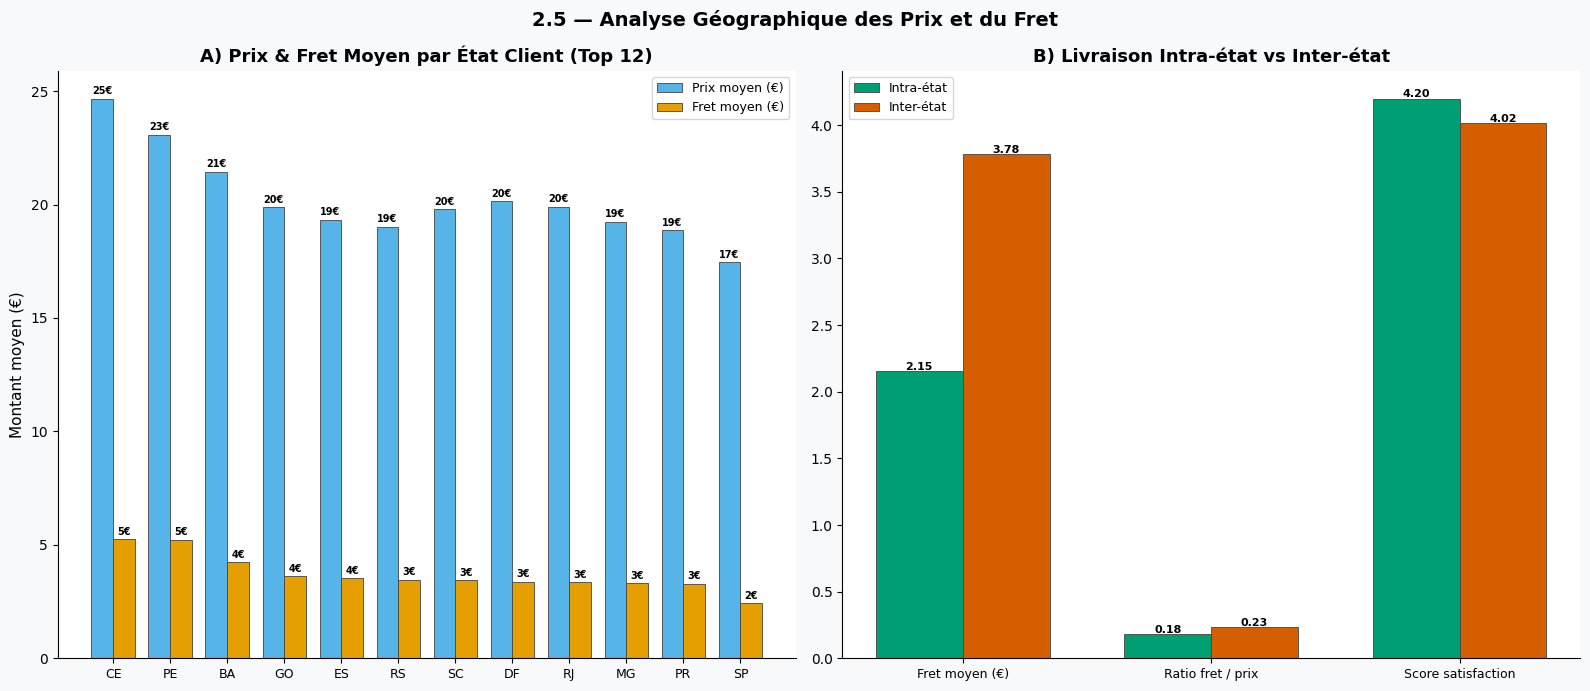


  💡 INSIGHT : La livraison inter-état coûte en moyenne 1.63 € de plus que la livraison intra-état — un surcoût logistique à intégrer dans la stratégie de prix par région.



In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("2.5 — Analyse Géographique des Prix et du Fret", fontsize=14, fontweight="bold")

# A) Prix moyen vs fret moyen par état (Top 12)
ax = axes[0]
top12 = state_price.head(12).sort_values("avg_freight", ascending=False)
x = np.arange(len(top12))
w = 0.38
b1 = ax.bar(x - w/2, top12["avg_price"], w,
            color=PALETTE[1], label="Prix moyen (€)", edgecolor="#444444", lw=0.6)
b2 = ax.bar(x + w/2, top12["avg_freight"], w,
            color=PALETTE[0], label="Fret moyen (€)", edgecolor="#444444", lw=0.6)
ax.set_xticks(x)
ax.set_xticklabels(top12["customer_state"], fontsize=9)
ax.set_ylabel("Montant moyen (€)")
ax.set_title("A) Prix & Fret Moyen par État Client (Top 12)")
ax.legend(fontsize=9)
for bar, val in zip(b1, top12["avg_price"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f"{val:.0f}€", ha="center", fontsize=7, fontweight="bold")
for bar, val in zip(b2, top12["avg_freight"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f"{val:.0f}€", ha="center", fontsize=7, fontweight="bold")

# B) Livraison locale vs distante
ax = axes[1]
metrics = ["avg_freight", "freight_ratio", "avg_review"]
labels  = ["Fret moyen (€)", "Ratio fret / prix", "Score satisfaction"]
x2 = np.arange(len(metrics))
w2 = 0.35
intra = geo_compare[geo_compare["same_state_delivery"] == 1]
inter = geo_compare[geo_compare["same_state_delivery"] == 0]

# Normalisation pour affichage comparatif
for i, (m, label) in enumerate(zip(metrics, labels)):
    v_intra = float(intra[m].values[0]) if len(intra) else 0
    v_inter = float(inter[m].values[0]) if len(inter) else 0
    ax.bar(i - w2/2, v_intra, w2, color=PALETTE[2],
           label="Intra-état" if i == 0 else "", edgecolor="#444444", lw=0.6)
    ax.bar(i + w2/2, v_inter, w2, color=PALETTE[5],
           label="Inter-état" if i == 0 else "", edgecolor="#444444", lw=0.6)
    ax.text(i - w2/2, v_intra + 0.01, f"{v_intra:.2f}",
            ha="center", fontsize=8, fontweight="bold")
    ax.text(i + w2/2, v_inter + 0.01, f"{v_inter:.2f}",
            ha="center", fontsize=8, fontweight="bold")

ax.set_xticks(x2)
ax.set_xticklabels(labels, fontsize=9)
ax.set_title("B) Livraison Intra-état vs Inter-état")
ax.legend(fontsize=9)

plt.tight_layout()
save_fig("phase2_25_geo.png")
plt.show()

diff_freight = (
    float(inter["avg_freight"].values[0]) - float(intra["avg_freight"].values[0])
    if len(inter) and len(intra) else 0
)
insight(f"La livraison inter-état coûte en moyenne {diff_freight:.2f} € de plus que la livraison "
        f"intra-état — un surcoût logistique à intégrer dans la stratégie de prix par région.")

---
## Synthèse des insights

Récapitulatif des observations clés pour les parties prenantes (Category Managers, Finance, E-commerce).

In [ ]:
print("=" * 65)
print("📋 PHASE 2 — SYNTHÈSE DES INSIGHTS PRICING")
print("=" * 65)

top_cat_margin = cat_margin.sort_values("total_margin", ascending=False).iloc[0]
top_cat_cv     = cat_price.sort_values("cv", ascending=False).iloc[0]
top_premium    = cat_price.iloc[0]
peak_month     = seasonal.loc[seasonal["mean"].idxmax(), "month_name"]
best_review    = seg_review.loc[seg_review["avg_review"].idxmax()]

print(f"""
  2.1 — POSITIONNEMENT PRIX
  • Catégorie premium      : {top_premium['category_en']} "
        (médiane {top_premium['median_price']:.2f} €)
  • Dispersion max (CV)    : {top_cat_cv['category_en']} "
        → révision tarifaire recommandée

  2.2 — MARGE
  • Catégorie prioritaire  : {top_cat_margin['category_en']}
        {top_cat_margin['margin_share']:.1f}% de la marge totale
        | {top_cat_margin['revenue_share']:.1f}% du CA

  2.3 — TENDANCES
  • Pic de prix             : {peak_month}
  • Opportunité             : pricing dynamique saisonnier

  2.4 — COMPORTEMENT CLIENT
  • Meilleure satisfaction  : segment '{best_review['price_segment_eur']}'
        (score {best_review['avg_review']:.2f}/5)
  • Corrélation prix/review : {corr:.3f} (faible → qualité perçue ≠ prix)

  2.5 — GÉOGRAPHIE
  • Surcoût inter-état      : +{diff_freight:.2f} € de fret moyen
  • Action recommandée      : ajustement prix par zone de livraison
""")

📋 PHASE 2 — SYNTHÈSE DES INSIGHTS PRICING

  2.1 — POSITIONNEMENT PRIX
  • Catégorie premium      : computers "
        (médiane 176.00 €)
  • Dispersion max (CV)    : art "
        → révision tarifaire recommandée

  2.2 — MARGE
  • Catégorie prioritaire  : health_beauty
        9.4% de la marge totale
        | 9.4% du CA

  2.3 — TENDANCES
  • Pic de prix             : Sep
  • Opportunité             : pricing dynamique saisonnier

  2.4 — COMPORTEMENT CLIENT
  • Meilleure satisfaction  : segment '48.0–80.0€'
        (score 4.13/5)
  • Corrélation prix/review : 0.003 (faible → qualité perçue ≠ prix)

  2.5 — GÉOGRAPHIE
  • Surcoût inter-état      : +1.63 € de fret moyen
  • Action recommandée      : ajustement prix par zone de livraison

  ➡️  Prêt pour Phase 2b — Modélisation de l'Élasticité-Prix
